# Banka İçin Fraud Detection Projesi
Bu notebook, kredi kartı işlemleri üzerinde sahte (fraud) işlemleri tespit etmek için geliştirdiğimiz makine öğrenmesi modelini içermektedir.

In [1]:
# Temel kütüphaneler
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Makine öğrenmesi bileşenleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)

# Grafiklerin notbook içinde görünmesi
%matplotlib inline


## 1. Veri Yükleme ve İlk İnceleme

In [2]:
# Veri setini yükleme
df = pd.read_csv("creditcard.csv")

print("İlk 5 satır:")
display(df.head())

print("\nVeri şekli (satır, sütun):", df.shape)

İlk 5 satır:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0



Veri şekli (satır, sütun): (166510, 31)


## 2. Veri Analizi (EDA) ve Sınıf Dağılımı

Sütunlar:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Veri tipi bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166510 entries, 0 to 166509
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    166510 non-null  float64
 1   V1      166510 non-null  float64
 2   V2      166510 non-null  float64
 3   V3      166510 non-null  float64
 4   V4      166510 non-null  float64
 5   V5      166510 non-null  float64
 6   V6      166510 non-null  float64
 7   V7      166510 non-null  float64
 8   V8      166509 non-null  float64
 9   V9      166509 non-null  float64
 10  V10     166509 non-null  float64
 11  V11     166509 non-null  float64
 12  V12     166509 non-null  float64
 13  V13     166509 non-

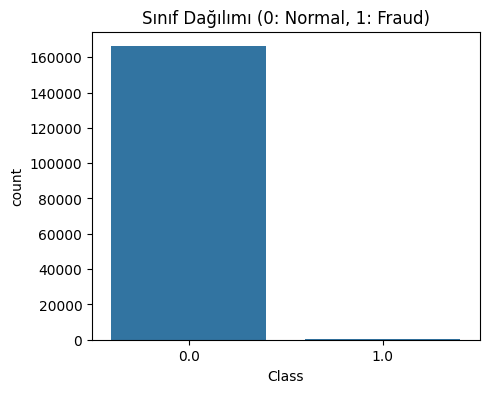

In [3]:
# Sütun isimleri
print("Sütunlar:")
print(df.columns)

# Veri tipi bilgisi
print("\nVeri tipi bilgisi:")
print(df.info())

# Sınıf dağılımı
print("\nSınıf (Class) dağılımı:")
print(df["Class"].value_counts())

# Sınıf dağılımını görselleştirelim
plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df)
plt.title("Sınıf Dağılımı (0: Normal, 1: Fraud)")
plt.show()

## 3. Veri Ön İşleme (Eksik Veriler ve Temizleme)

In [4]:
# Eksik değer kontrolü
print("Eksik değer sayıları:")
print(df.isnull().sum())

# Çok az eksik değer olduğu için, eksik satırları silebiliriz
df = df.dropna()

print("\nTemizlendikten sonra veri boyutu:", df.shape)
print("\nYeni Class dağılımı:")
print(df["Class"].value_counts())

Eksik değer sayıları:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

Temizlendikten sonra veri boyutu: (166509, 31)

Yeni Class dağılımı:
Class
0.0    166151
1.0       358
Name: count, dtype: int64


## 4. Train-Test Ayrımı ve Özellik Ölçekleme

In [5]:
# Özellikler (X) ve hedef (y) ayrımı
X = df.drop("Class", axis=1)
y = df["Class"]

# Train / Test bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # sınıf dağılımını korur
)

print("Train set boyutu:", X_train.shape)
print("Test set boyutu:", X_test.shape)

# Logistic Regression için ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train set boyutu: (133207, 30)
Test set boyutu: (33302, 30)


## 5. Model 1 – Logistic Regression

In [6]:
# Logistic Regression modeli
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_log = log_model.predict(X_test_scaled)

print("==== LOGISTIC REGRESSION SONUÇLARI ====")
print(classification_report(y_test, y_pred_log, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

==== LOGISTIC REGRESSION SONUÇLARI ====
              precision    recall  f1-score   support

         0.0     0.9991    0.9996    0.9994     33230
         1.0     0.7818    0.5972    0.6772        72

    accuracy                         0.9988     33302
   macro avg     0.8905    0.7984    0.8383     33302
weighted avg     0.9987    0.9988    0.9987     33302

Confusion Matrix:
[[33218    12]
 [   29    43]]


## 6. Model 2 – Random Forest

In [7]:
# Random Forest modeli
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("==== RANDOM FOREST SONUÇLARI ====")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

==== RANDOM FOREST SONUÇLARI ====
              precision    recall  f1-score   support

         0.0     0.9996    1.0000    0.9998     33230
         1.0     0.9836    0.8333    0.9023        72

    accuracy                         0.9996     33302
   macro avg     0.9916    0.9167    0.9510     33302
weighted avg     0.9996    0.9996    0.9996     33302

Confusion Matrix:
[[33229     1]
 [   12    60]]


## 7. Random Forest Confusion Matrix Görselleştirme


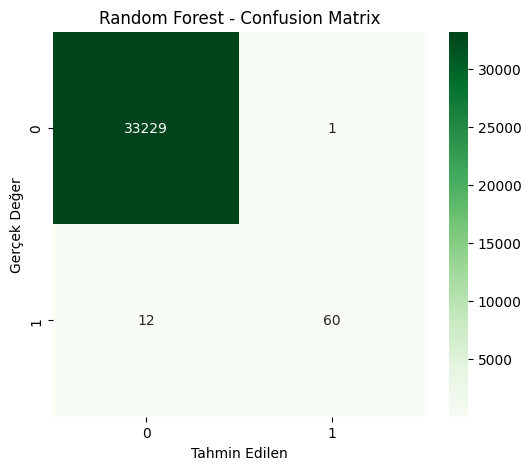

In [8]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

## 8. Fraud Olasılık Skoru (Risk Analizi)

In [9]:
# Her işlem için fraud olasılığını (risk skorunu) gösterelim
fraud_probabilities = rf_model.predict_proba(X_test)

print("İlk 10 işlem için fraud olasılığı:")
for i in range(10):
    print(f"İşlem {i+1} - Fraud olasılığı: %{fraud_probabilities[i][1]*100:.2f}")


# Tek bir işlem için detaylı tahmin yapan fonksiyon
def predict_transaction(index):
    prob = rf_model.predict_proba(X_test.iloc[[index]])[0][1]
    result = rf_model.predict(X_test.iloc[[index]])[0]

    print(f"İşlem index'i: {index}")
    print(f"Fraud olasılığı: %{prob*100:.2f}")
    print("Tahmin:", "FRAUD ❌" if result == 1 else "NORMAL ✅")

# Örnek kullanım
predict_transaction(5)

İlk 10 işlem için fraud olasılığı:
İşlem 1 - Fraud olasılığı: %0.00
İşlem 2 - Fraud olasılığı: %0.00
İşlem 3 - Fraud olasılığı: %0.00
İşlem 4 - Fraud olasılığı: %0.00
İşlem 5 - Fraud olasılığı: %0.00
İşlem 6 - Fraud olasılığı: %0.00
İşlem 7 - Fraud olasılığı: %0.00
İşlem 8 - Fraud olasılığı: %0.00
İşlem 9 - Fraud olasılığı: %0.00
İşlem 10 - Fraud olasılığı: %0.00
İşlem index'i: 5
Fraud olasılığı: %0.00
Tahmin: NORMAL ✅


## 9. ROC Eğrisi ve AUC Değeri

Bu bölümde, Random Forest modelimizin farklı eşik değerlerindeki performansını ROC eğrisi ile inceleyip, genel başarısını AUC değeri ile özetliyoruz.

AUC değeri: 0.9836


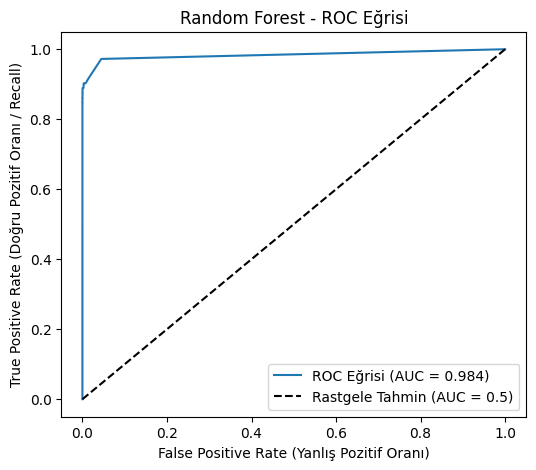

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

# Modelin her işlem için "fraud olma olasılığı" skorları
y_score = rf_model.predict_proba(X_test)[:, 1]

# ROC eğrisi için gerekli değerler
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# AUC (Area Under Curve) değeri
auc_value = roc_auc_score(y_test, y_score)
print(f"AUC değeri: {auc_value:.4f}")

# ROC eğrisini çizelim
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Eğrisi (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Rastgele Tahmin (AUC = 0.5)")
plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")
plt.ylabel("True Positive Rate (Doğru Pozitif Oranı / Recall)")
plt.title("Random Forest - ROC Eğrisi")
plt.legend(loc="lower right")
plt.show()